## AHEAD DWI preprocessing script
    Code by: Pilou Bazin & Max Keuken (mckeuken@gmail.com)
             Integrative Model-based Cognitive Neuroscience 
             (IMCN) research unit, University of Amsterdam
    Date:    Dec 2020 / Jan 2021
    Version: 1.1
    
##### Description of the project
    As part of a larger project (AHEAD) a number of subjects underwent a number of 3T and 7T MRI scans.
    These scans were either structural, functional or DWI and took place in 2019 and 2020. The 7T structural 
    scans have already been shared in a publications. While the 3T DWI data was acquired and Pilou already 
    started on a pipeline to preprocess the data, it has yet to be applied to all the subjects.
    I've adjusted and extended the pipeline by Pilou and ran it for the 50 subjects for which we have a
    complete DWI dataset. 

##### Description of the MRI acquisition
    Based on the filenames in the par/rec data we acquired the following data:
    1) B0 check
    2) 2x B0 for topup
    3) a 64 direction DWI sequence, split in half (so 2x 32 directions)
        - bvalue of 1600
    4) 2x B0 for topup 
    5) a 56 direction DWI sequence
        - bvalue of 1000
        - 5 additional B0 volumes at the end of the volume
    6) 2x B0 for topup 
    7) a 48 direction DWI sequence
        - bvalue of 700
    All above sequences should have an isotropic resolution of 1.28mm

##### Description of the pipeline
    There are a number of steps that we do
    0) Preperatory stuff
        a) Import modules
        b) Define a few custom plotting functions
        c) Define a number of variables (subjectID, working directory etc)
    1) Prepare the data for FSL
        a) Only select the B0 and DWI scans to export
        b) Convert the PAR/REC or DICOM files to Nifti (which also creates the bvecs and bvals)
    Control 1)
        - Do all subjects have all the data?
        - Do the scans match the expected dimenion?
    2) Trim the data if the dimension of the file is not consistant
    3) Prepare the data for mrtrix3
        a) Convert the Nifti files from step 1 to Mif 
        b) Concatenate the files
    4) Denoise the data
        a) The concatenated files from step 2b are denoised using mrtrix3
    5) DeGibbs the denoised data. This is can be done by two different options:
        a) Custom option1 by Mathaan Caan
        b) Mrtrix3 standard function <- This is the option that we settled on. 
    Control 2) 
        - How do the two options compare to one and other?
    6) Apply Topup to the data
    7) Apply eddy current correction to the data
    8) Apply a bias correction to the data
    9) Fit a tensor model to the data so that you can check the results
    10) Move the preprocessed data to the AHEAD BIDS public folder
    
##### Software versions
    parrec2nii: V3.2.1
    dcm2niix: V1.0.20201216
    mrtrix: V3.0.2
    fsl: V5.0.11
    ants: V2.2.0.dev3-g8084e
    
    All code that follows has been succesfully run on the subjects.

In [1]:
#################################################################################
## Import the modules
#################################################################################
import nighres 
import numpy as np
import nibabel as nib
import subprocess
from multiprocessing import Pool
import os
import glob
import shutil
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#################################################################################

In [2]:
#################################################################################
## Custom functions
#################################################################################

# Visualizing the scans
def save_slices(slices, vminCustom, vmaxCustom, figurename):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize=(15,15))
    for i, slice in enumerate(slices):
        threePanelFigure = axes[i].imshow(slice.T, cmap="gray", origin="lower", vmin = vminCustom, vmax= vmaxCustom)
        threePanelFigure.figure.savefig(figurename, format = 'png')
    plt.close(fig)
    
def show_slices(slices, vminCustom, vmaxCustom, figurename):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize=(15,15))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower", vmin = vminCustom, vmax= vmaxCustom)
    
# Selecting and visualizing the middle slice of a scan
def show_middle_slices(mriInputFile, figurename):
    """ Function to check if the image is 3D or 4D and then select the middle image to visualize """
    # select the slice by first checking the shape of the file
    shapeMRIFile = mriInputFile.shape
    # Based on the range of values we want to change the vmax of the visualization
    vminCustom = np.percentile(mriInputFile, 25)
    vmaxCustom = np.percentile(mriInputFile, 95)
    # For files that have 4 dimensions:
    if len(shapeMRIFile) == 4:
        # Show me the middle slice
        slice_0 = mriInputFile[int(round((mriInputFile.shape[0]/2),0)), :, :, int(round((mriInputFile.shape[3]/2),0))]
        slice_1 = mriInputFile[:, int(round((mriInputFile.shape[1]/2),0)), :, int(round((mriInputFile.shape[3]/2),0))]
        slice_2 = mriInputFile[:, :, int(round((mriInputFile.shape[2]/2),0)), int(round((mriInputFile.shape[3]/2),0))]
        save_slices([slice_0, slice_1, slice_2], vminCustom, vmaxCustom, figurename )
    # For files that have 3 dimensions:
    elif len(shapeMRIFile) == 3:
        # Show me the middle slice
        slice_0 = mriInputFile[int(round((mriInputFile.shape[0]/2),0)), :, :]
        slice_1 = mriInputFile[:, int(round((mriInputFile.shape[1]/2),0)), :]
        slice_2 = mriInputFile[:, :, int(round((mriInputFile.shape[2]/2),0))]
        save_slices([slice_0, slice_1, slice_2], vminCustom, vmaxCustom, figurename)
    # For files that have n dimensions other than 3 or 4:
    else: 
        print('Something is rotten in the state of Denmark..')

# Trim the bvals and bvecs for adjusted nifti files
def trimBvalsAndBvecs(scan,dimensions):
    bvalName = scan.replace('.nii.gz', '.bvals')
    bvecName = scan.replace('.nii.gz', '.bvecs')
    trimmedScanName = scan.replace('.nii.gz', '_trim.nii.gz')
    trimmedbvalName = bvalName.replace('.bvals', '_trim.bvals')
    trimmedbvecName = bvecName.replace('.bvec', '_trim.bvec')
    np.savetxt(trimmedbvalName, bvals[:dimensions].flatten(), fmt= '%1.1f', newline = ' ')
    np.savetxt(trimmedbvecName, bvecs[:dimensions].T, fmt= '%1.3f')
#################################################################################

In [3]:
#################################################################################
## Set a number of variables:
#################################################################################

# Corresponding PAR/REC and Dicom folder location
# We have 3 participants for which we did not have the parrecs but the dicoms instead:
dicom_dir = '/home/mkeuken1/Documents/Projects/AHEAD-DWI-Preprocessing/Data/_DCM_3T/R03/'
parrec_dir = '/home/mkeuken1/Documents/Projects/AHEAD-DWI-Preprocessing/Data/_PARREC_3T/R03/'

# Subject ID's
# AHEAD database
subjects_dicom = os.listdir(dicom_dir)
subjects_parrec = os.listdir(parrec_dir)
subjects = subjects_parrec+subjects_dicom
subjects.sort()

# BIDS:
# Extract the bids name from the AHEAD naming:
subjects_bidsTmp = [item.lower() for item in subjects]
subjects_bids=[]
for i in range(len(subjects_bidsTmp)):
    if 'pilot' in subjects_bidsTmp[i]:
        bidsName = 'sub-'+'000'
    else:
        bidsName ='sub-'+subjects_bidsTmp[i][11:14]
    subjects_bids.append(bidsName)
    
# Scan parameters
# assuming those don't change.. (in any case, the ratio is constant in all tested cases)
total_readout_time=0.096869
total_readout_topup=0.097026

# Based on the control checks there are a few subjects that we are going to exclude for now
subjectsFullGroup = subjects
subjectsbidsFullGroup = subjects_bids
print('Initially we have ', len(subjects_bids), ' subjects')
unwanted_subjects = {'Subcortex_0051_050_R03', 'Subcortex_0055_055_R03', 'Subcortex_0067_067_R03',  'Subcortex_0075_075_R03', 'Subcortex_0077_078_R03' }
unwanted_subjects_bids = {'sub-051', 'sub-055', 'sub-067',  'sub-075' , 'sub-077' }
subjects = [subject for subject in subjects if subject not in unwanted_subjects] 
subjects_bids = [subject for subject in subjects_bids if subject not in unwanted_subjects_bids]
print('After selection we have ', len(subjects_bids), ' subjects')
#################################################################################

Initially we have  55  subjects
After selection we have  50  subjects


In [ ]:
#################################################################################
## Create the working and output directory
#################################################################################
for i in range(len(subjects)):
    # Folder settings 
    # At the moment own folder, otherwise work is in tmp and output is in public
    work_dir = '/home/mkeuken1/Documents/Projects/AHEAD-DWI-Preprocessing/tmp/dwi_preprocessing/'+subjects[i]
    output_dir_local = '/home/mkeuken1/Documents/Projects/AHEAD-DWI-Preprocessing/HumanAtlas_BIDS/'+subjects_bids[i]+'/ses-3/dwi'
    output_dir_public = '/home/public/HumanAtlas_BIDS/'+subjects_bids[i]+'/ses-3/dwi'
    print(subjects[i], subjects_bids[i] )
    # Make working dir if it doesn't exist
    if not os.path.exists(work_dir):
        print('Create temporary work directory')
        os.makedirs(work_dir, exist_ok=True)
    # Make output dir local if it doesn't exist
    if not os.path.exists(output_dir_local):
        print('Create Output directory')
        os.makedirs(output_dir_local, exist_ok=True)
    # Make output dir public if it doesn't exist
    if not os.path.exists(output_dir_public):
        print('Create Output directory public')
        os.makedirs(output_dir_public, exist_ok=True)
#################################################################################  

In [ ]:
#################################################################################
## 1. Convert raw data to Nifti using dcm2niix or parrec2nii
#################################################################################
summaryScans = []
for i in range(len(subjects)):
    work_dir = '/home/mkeuken1/Documents/Projects/AHEAD-DWI-Preprocessing/tmp/dwi_preprocessing/'+subjects[i]
    
    # First all the parrecs:
    if subjects[i] in subjects_parrec:
        # First only select the data that we want to export to nifti:
        # For a few subjects we have extra B0 checks which we don't want to export to nifti
        #. It is also a bit of a pain to move them later as the regular expression *dwi* is used to 
        #. select all DWI relevant scans. Therefore we move the B0 extra check to a new folder:
        #
        # Make a folder where we move the unwanted files:
        scansOfNoInterest_dir = '/scansOfNoInterest'
        if (os.path.exists(parrec_dir+subjects[i]+scansOfNoInterest_dir)):
            print('selection of scans: done (delete dir to recompute)')
        else:
            os.makedirs(parrec_dir+subjects[i]+scansOfNoInterest_dir,exist_ok=True)
        # For all scans for a given person we want move all the 'B0 check' scans to this new folder
        tmpScans = glob.glob(parrec_dir+subjects[i]+'/*check*' , recursive=False)
        for scan in tmpScans:
            shutil.move(scan, parrec_dir+subjects[i]+scansOfNoInterest_dir)

        # Start the actual conversion of par/rec to nifti   
        convert_dir = '/parrecORdcm2nii'
        if (os.path.exists(work_dir+convert_dir)):
            print('Conversion to Nifti: done (delete dir to recompute)')
        else:
            os.makedirs(work_dir+convert_dir,exist_ok=True)
            print('\n1. Convert PARREC into Nifti files: dwi data')
            command = "parrec2nii --overwrite -p --strict-sort --scaling='fp' --bvs --compressed --output-dir "+work_dir+convert_dir+' '+parrec_dir+subjects[i]+"/"+subjects[i]+"*dwi*.PAR"
            # p: truncated images allowed
            # strict-sort: Addional keys in the rec files are used to sort the data
            # scaling: floating point
            # bvs: output bvals/bvecs
            # Compressed: nii.gz
            print(subjects_bids[i])
            print(command)
            try:
                subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
            except subprocess.CalledProcessError as e:
                msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
                raise subprocess.CalledProcessError(msg)

        ## After DICOM to Nifti conversion using dcm2niix we want to do a few sanity checks:

        # C. Visualize the different dwi scans and give the shape of the converted files
        tmpScans = glob.glob(work_dir+convert_dir+'/*.nii.gz' , recursive=False)

        # For the given scans 
        for scan in tmpScans:
            # Load the image
            dwi_img = nib.load(scan)
            # Get the actual data
            dwi_img_data = dwi_img.get_fdata()

            # Get some summary stats on the image and combine them in the list:
            dwi_img_shape = dwi_img_data.shape
            dwi_img_voxelSize = nib.affines.voxel_sizes(dwi_img.affine)
            summaryScans.append([subjects[i], scan.rpartition('/')[-1], dwi_img_shape, np.round(dwi_img_voxelSize, 2)])

    # Then all the dicoms:
    elif subjects[i] in subjects_dicom:
        # Start the actual conversion of dicom to nifti   
        convert_dir = '/parrecORdcm2nii'
        if (os.path.exists(work_dir+convert_dir)):
            print('Conversion to Nifti: done (delete dir to recompute)')
        else:
            os.makedirs(work_dir+convert_dir,exist_ok=True)
            print('\n1. Convert Dicom into Nifti files: dwi data')
            command = "dcm2niix -o "+work_dir+convert_dir+' -z y '+dicom_dir+subjects[i]
            # -o output
            # -z gz compression
            print(subjects_bids[i])
            print(command)
            try:
                subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
            except subprocess.CalledProcessError as e:
                msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
                raise subprocess.CalledProcessError(msg)

        ## After DICOM to Nifti conversion using dcm2niix we end up with a few unwanted files. 
        # Make a folder where we move the unwanted files:
        scansOfNoInterest_dir = '/scansOfNoInterest'
        if (os.path.exists(work_dir+convert_dir+scansOfNoInterest_dir)):
            print('selection of scans: done (delete dir to recompute)')
        else:
            os.makedirs(work_dir+convert_dir+scansOfNoInterest_dir,exist_ok=True)
        # Which files do we want to move?
        # 'B0 check' 
        tmpScansCheck = glob.glob(work_dir+convert_dir+'/*check*' , recursive=False)
        for scan in tmpScansCheck:
            shutil.move(scan, work_dir+convert_dir+scansOfNoInterest_dir)
        # 'json check' 
        tmpScansJson = glob.glob(work_dir+convert_dir+'/*.json' , recursive=False)
        for scan in tmpScansJson:
            shutil.move(scan, work_dir+convert_dir+scansOfNoInterest_dir)
        # 't1
        tmpScansT1 = glob.glob(work_dir+convert_dir+'/*T1w*' , recursive=False)
        for scan in tmpScansT1:
            shutil.move(scan, work_dir+convert_dir+scansOfNoInterest_dir)
            
        ## Another issue with dcm2niix versus parrec2nifti is that the bval en bvec files 
        #. have slightly different file ending: bval vs bvals..
        #. Lets rename them:
        #. Bval
        command = "rename 's/bval/bvals/' "+work_dir+convert_dir+"/*.bval"
        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)
        #. Bvecs
        command = "rename 's/bvec/bvecs/' "+work_dir+convert_dir+"/*.bvec"
        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)
            
        # C. Visualize the different dwi scans and give the shape of the converted files
        tmpScans = glob.glob(work_dir+convert_dir+'/*.nii.gz' , recursive=False)

        # For the given scans 
        for scan in tmpScans:
            # Load the image
            dwi_img = nib.load(scan)
            # Get the actual data
            dwi_img_data = dwi_img.get_fdata()

            # Get some summary stats on the image and combine them in the list:
            dwi_img_shape = dwi_img_data.shape
            dwi_img_voxelSize = nib.affines.voxel_sizes(dwi_img.affine)
            summaryScans.append([subjects[i], scan.rpartition('/')[-1], dwi_img_shape, np.round(dwi_img_voxelSize, 2)])

            # Visualize the data
            #. Uncomment next line if you want to see the middle slices of all scans (not very memory friendly)
            # show_middle_slices(dwi_img_data)
   
# Format the summarylist into a dataframe: 
dfSummaryScans = pd.DataFrame(summaryScans, columns=['Subject', 'Scan', 'Shape', 'VoxelSize'])
dfSummaryScans = dfSummaryScans.sort_values(by = ['Subject', 'Scan'])
#################################################################################

In [ ]:
#################################################################################
## Control 1)
#################################################################################
# Based on the par/rec to nifti export we know that for a few subjects a number of scans were either corrupt or missing:
#. 0067 file, 2nd half 64 directions that we got from the SC is corrupt
#. 0075 file, missing a par file 
#. 0077 file, 56 direction is corrupt, 64 directions 2nd half is corrupt

# So Let check for all subjecs the number of scans: 
display(dfSummaryScans.groupby('Subject')['Scan'].nunique())

# There are 3 subjects for which is is clear that we are missing quite a lot of data:
#. 0051, 0055, 0075 (missing a matching par file)
#. Based on the export and files we want to know what happend to these 5 subjects and whether we can retrieve the data
#. Wat I did was contact Matthan Caan and Diederik Stoffel from the Spinoza Center (where the data was acquired). Based on 
#. the data that was available on their server it did not solve the problem of missing data or corrupt data. So it seems
#. that something happend when exporting/closing the scanning session with those participants.
#. I also double checked with Nikita van Berendonk to see if something happend during those sessions. Based on the google
#. drive document nothing of note happend durign the acquistion session.

#. Then the other subject that is off is the initial Pilot dataset where there are a lot more B0's than the other scans. Not a bad thing but it
#. is something to note.

# For now we are going to drop the 5 subjects for which we are really missing the DWI data from further processing: 
#. 'sub-051', 'sub-055', 'sub-067',  'sub-075' , 'sub-077' 
#. The notebook has been adjusted to remove these 5 subjects and has been rerun again. 

# Note that the dimensions of the dwi56 did not match the number of expected directions (directions + 1 B0) 57 vs 62. After talking to Matthan Caan
#. it appears that these 5 extra volumes are extra B0 Scans (bval is 0, therefore bvecs are not relevant). So this is correct.
#################################################################################

In [ ]:
#################################################################################
## 2. Convert to MRtrix3 format
#################################################################################
for i in range(len(subjects)):
    work_dir = '/home/mkeuken1/Documents/Projects/AHEAD-DWI-Preprocessing/tmp/dwi_preprocessing/'+subjects[i]
    
    # We use the output of step 1) parrec2nii
    convert_dir = '/parrecORdcm2nii'
    mrtrix_dir = '/nii2mif'
    if (os.path.exists(work_dir+mrtrix_dir)):
        print('Conversion to Mrtrix3: done (delete dir to recompute)')
    else:
        os.makedirs(work_dir+mrtrix_dir,exist_ok=True)

        print('\n2. Convert Nifti files into Mrtrix3 files')
        bval_files = glob.glob(work_dir+convert_dir+'/*.bvals')
        for bval_file in bval_files:
            bvec_file = bval_file.replace('.bvals','.bvecs')
            data_file = bval_file.replace('.bvals','.nii.gz')
            mif_file = bval_file.replace('.bvals','.mif.gz')
            mif_file = mif_file.replace(convert_dir,mrtrix_dir)

            command = 'mrconvert -fslgrad '+bvec_file+' '+bval_file+' '+data_file+' '+mif_file

            print(command)
            try:
                subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
            except subprocess.CalledProcessError as e:
                msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
                raise subprocess.CalledProcessError(msg)

        topup_files = glob.glob(work_dir+convert_dir+'/*TOPUP*.nii.gz')
        # We have to treat the first subject differently because the topup files are not identical
        if subjects[i] != 'Subcortex_pilot_dMRI_20190415':
            for topup_file in topup_files:
                data_file = topup_file
                bval_file = 'dummy_topup.bvals'
                bvec_file = 'dummy_topup.bvecs'
                mif_file = topup_file.replace('.nii.gz','.mif.gz')
                mif_file = mif_file.replace(convert_dir,mrtrix_dir)

                command = 'mrconvert '+data_file+' '+mif_file

                print(command)
                try:
                    subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
                except subprocess.CalledProcessError as e:
                    msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
                    raise subprocess.CalledProcessError(msg)
        elif subjects[i] == 'Subcortex_pilot_dMRI_20190415':
            for topup_file in topup_files:
                try:
                    data_file = topup_file
                    bval_file = data_file.replace('.nii.gz','.bvals')
                    bvec_file = data_file.replace('.nii.gz','.bvecs')
                    mif_file = data_file.replace('.nii.gz','.mif.gz')
                    mif_file = mif_file.replace(convert_dir,mrtrix_dir)

                    command = 'mrconvert -fslgrad '+bvec_file+' '+bval_file+' '+data_file+' '+mif_file

                    print(command)
                    subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
                 
                except:
                    data_file = topup_file
                    bval_file = 'dummy_topup.bvals'
                    bvec_file = 'dummy_topup.bvecs'
                    mif_file = topup_file.replace('.nii.gz','.mif.gz')
                    mif_file = mif_file.replace(convert_dir, mrtrix_dir)

                    command = 'mrconvert -force '+data_file+' '+mif_file

                    print(command)
                    subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
                   
        print('\n CHECK: are there any files you need to remove from among these: '+str(glob.glob(work_dir+mrtrix_dir+'/*.mif.gz')))
#################################################################################

In [ ]:
#################################################################################
## 3. Concatenate all dwi images into a single one where the topup files are treated seperately
#################################################################################
for i in range(len(subjects)):
    work_dir = '/home/mkeuken1/Documents/Projects/AHEAD-DWI-Preprocessing/tmp/dwi_preprocessing/'+subjects[i]

    # Afther the mrtrix3 step we 
    concat_dir = '/concat'
    if (os.path.exists(work_dir+concat_dir)):
        print('Data combination: done (delete dir to recompute)')
    else:
        print('\n3. Concatenate dwi and topup files into a single file each')
        os.makedirs(work_dir+concat_dir,exist_ok=True)
        mif_files = glob.glob(work_dir+mrtrix_dir+'/*.mif.gz')

        dwi_files = []
        topup_files = []
        for mif_file in mif_files:
            if mif_file.find('TOPUP')>-1 or mif_file.find('topup')>-1:
                topup_files.append(mif_file)
            else:
                dwi_files.append(mif_file)

        print('\nmerge '+str(len(dwi_files))+' dwi files')
        command = 'mrcat -axis 3 '
        for dwi_file in dwi_files:
            command = command+dwi_file+' '
        command = command+work_dir+concat_dir+'/dti_raw.mif.gz'

        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)

        print('\nmerge '+str(len(topup_files))+' topup files')
        command = 'mrcat -axis 3 '
        for topup_file in topup_files:
            command = command+topup_file+' '
        command = command+work_dir+concat_dir+'/dti_topup_raw.mif.gz'

        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)
#################################################################################

In [ ]:
#################################################################################
# 4. Denoise the data
#################################################################################
# Switching to Luka Liebrand's customized script (recoded in python for general use)
# The DWI raw data and the topup files are treated seperately
for i in range(len(subjects)):
    work_dir = '/home/mkeuken1/Documents/Projects/AHEAD-DWI-Preprocessing/tmp/dwi_preprocessing/'+subjects[i]

    # DWI Data
    denoise_dir = '/denoise'
    if (os.path.exists(work_dir+denoise_dir)):
        print('Denoising: done (delete dir to recompute)')
    else:
        print('\n4. Denoise raw DWI files')
        os.makedirs(work_dir+denoise_dir,exist_ok=True)
        # Does the actual denoising using mrtrix
        # The extend of 3x3x3 is the denoising filter which is slighty smaller than standard (5)
        command = 'dwidenoise -nthreads 4 -extent 3,3,3'
        command = command +' -noise '+work_dir+denoise_dir+'/dti_noisemap.mif.gz'
        command = command +' '+work_dir+concat_dir+'/dti_raw.mif.gz'
        command = command +' '+work_dir+denoise_dir+'/dti_denoised.mif.gz'

        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)
        # Creating a (noise) residual
        # Checked a number of residual volumes, grey and white matter seems to be 'blurry'
        #. as you would expect. So this seems to be doing its job.
        command = 'mrcalc '+work_dir+concat_dir+'/dti_raw.mif.gz'
        command = command +' '+work_dir+denoise_dir+'/dti_denoised.mif.gz'
        command = command +' -subtract '+work_dir+denoise_dir+'/dti_residuals.mif.gz'

        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)

    # DWI TOPUP data
    denoise_tp_dir = '/denoise_tp'
    if (os.path.exists(work_dir+denoise_tp_dir)):
        print('Denoising topup: done (delete dir to recompute)')
    else:
        print('\n4. Denoise raw topup DWI files')
        os.makedirs(work_dir+denoise_tp_dir,exist_ok=True)

        command = 'dwidenoise -nthreads 4 -extent 3,3,3'
        command = command +' -noise '+work_dir+denoise_tp_dir+'/dti_tp_noisemap.mif.gz'
        command = command +' '+work_dir+concat_dir+'/dti_topup_raw.mif.gz'
        command = command +' '+work_dir+denoise_tp_dir+'/dti_tp_denoised.mif.gz'

        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)

        command = 'mrcalc '+work_dir+concat_dir+'/dti_topup_raw.mif.gz'
        command = command +' '+work_dir+denoise_tp_dir+'/dti_tp_denoised.mif.gz'
        command = command +' -subtract '+work_dir+denoise_tp_dir+'/dti_tp_residuals.mif.gz'

        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)
#################################################################################

In [ ]:
#################################################################################
## 5. Degibbs the data
#################################################################################
# option 1) Remove gibbs artifacts 
# by Mathaan Caan 
# He creates a derivative for the BO image for all values, if they are negative 
#. they become 0 and the BO image is combined with the deriavative.
#. Note that he only does the DWI data here, the topup input files are done later
for i in range(len(subjects)):
    work_dir = '/home/mkeuken1/Documents/Projects/AHEAD-DWI-Preprocessing/tmp/dwi_preprocessing/'+subjects[i]
                                                                                                           
    degibbs_dir = '/degibbs-option1'
    if (os.path.exists(work_dir+degibbs_dir)):
        print('De-Gibbs: done (delete dir to recompute)')
    else:
        print('\n5a. Removing Gibbs ringing artefact from denoised DWI files')
        os.makedirs(work_dir+degibbs_dir,exist_ok=True)

        ## here we adapt Matthan Caan's de-Gibbs script ##
        # 1. Convert back to Nifti
        command = 'mrconvert -export_grad_fsl '+work_dir+degibbs_dir+'/dti_denoised.bvec'
        command = command +' '+work_dir+degibbs_dir+'/dti_denoised.bval'
        command = command +' '+work_dir+denoise_dir+'/dti_denoised.mif.gz'
        command = command +' '+work_dir+degibbs_dir+'/dti_denoised.nii.gz'
    
        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)

        # 2. Do the processing
        print('Compute second derivatives for B0 images')
        infile = open(work_dir+degibbs_dir+'/dti_denoised.bval', 'r')
        bvals = [float(w) for w in infile.read().split()]
        infile.close()

        img = nighres.io.load_volume(work_dir+degibbs_dir+'/dti_denoised.nii.gz')
        data = img.get_fdata()

        # only for B0 values (e.g.bval < 100)
        for idx,bval in enumerate(bvals):
            if bval<100:
                print('found B0: '+str(bval))
                bzero = data[:,:,:,idx]

                deriv = np.gradient(np.gradient(bzero,axis=0),axis=0)+np.gradient(np.gradient(bzero,axis=1),axis=1)
                deriv[deriv<0] = 0

                bzero = bzero + deriv
                data[:,:,:,idx] = bzero

        img = nib.Nifti1Image(data, affine=img.affine,header=img.header)
        nighres.io.save_volume(work_dir+degibbs_dir+'/dti_unring.nii.gz', img)
#################################################################################

In [ ]:
#################################################################################
## 5. Degibbs the data
#################################################################################
#. option 2) use the MRtrix3 tools
for i in range(len(subjects)):
    work_dir = '/home/mkeuken1/Documents/Projects/AHEAD-DWI-Preprocessing/tmp/dwi_preprocessing/'+subjects[i]
    degibbs2_dir = '/degibbs-option2'
    if (os.path.exists(work_dir+degibbs2_dir)):
        print('De-Gibbs ringing by MRtrix: done (delete dir to recompute)')
    else:
        print('\n5b. De-Gibbs denoised DWI files (MRtrix version)')
        os.makedirs(work_dir+degibbs2_dir,exist_ok=True)

        command = 'mrdegibbs -nthreads 4 -axes 0,1'
        command = command +' '+work_dir+denoise_dir+'/dti_denoised.mif.gz'
        command = command +' '+work_dir+degibbs2_dir+'/dti_unring2.mif.gz'

        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)
        # Converting the output back again to nifti output
        command = 'mrconvert -export_grad_fsl '+work_dir+degibbs2_dir+'/dti_unring2.bvec'
        command = command +' '+work_dir+degibbs2_dir+'/dti_unring2.bval'
        command = command +' '+work_dir+degibbs2_dir+'/dti_unring2.mif.gz'
        command = command +' '+work_dir+degibbs2_dir+'/dti_unring2.nii.gz'

        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)
#################################################################################

In [ ]:
#################################################################################
## So how do these two de-gibb methods compare?
#################################################################################
deGibbsComparison = []
degibbs1_dir = '/degibbs-option1'
degibbs2_dir = '/degibbs-option2'
degibbsComparisons = '/home/mkeuken1/Documents/Projects/AHEAD-DWI-Preprocessing/tmp/degibbs-comparison/'
if (os.path.exists(degibbsComparisons)):
    print('De-Gibbs figures: done (delete dir to recompute)')
else:
    print('\n5b. Creating degibbs Comparison files')
    os.makedirs(degibbsComparisons, exist_ok=True)
    
for i in range(len(subjects)):
    print(subjects[i])
    work_dir = '/home/mkeuken1/Documents/Projects/AHEAD-DWI-Preprocessing/tmp/dwi_preprocessing/'+subjects[i]
    
    # Load in the data
    # Denoised data:
    denoisedFile = nib.load(work_dir+degibbs1_dir+'/dti_denoised.nii.gz')
    denoisedData = denoisedFile.get_fdata()
    denoisedDataB0 = denoisedData[:,:,:,0]

    # degibbs option 1 data:
    degibbsOption1File = nib.load(work_dir+degibbs1_dir+'/dti_unring.nii.gz')
    degibbsOption1Data = degibbsOption1File.get_fdata()
    degibbsOption1DataB0 = degibbsOption1Data[:,:,:,0]

    # degibbs option 2 data:
    degibbsOption2File = nib.load(work_dir+degibbs2_dir+'/dti_unring2.nii.gz')
    degibbsOption2Data = degibbsOption2File.get_fdata()
    degibbsOption2DataB0 = degibbsOption2Data[:,:,:,0]

    # Show me the middle slice or the B0 and give me some descriptives
    subject = subjects[i]
    scans = [denoisedData, degibbsOption1Data, degibbsOption2Data, denoisedDataB0, degibbsOption1DataB0, degibbsOption2DataB0]
    scanNames = ['Denoised', 'deGibbsOption1', 'deGibbsOption2']*2
    scanSelection = np.repeat(['AllSlices', 'OnlyFirstB0'], 3, axis = 0 )

    for i in range(0, len(scans)):
        # calculate some descriptives:
        scanMean = scans[i].mean()
        scanSd   = scans[i].std()
        scanCV   = scanMean/scanSd
        figurename = degibbsComparisons+subject+'_'+scanNames[i]+'_'+scanSelection[i]
        # calculate the difference in CV compared to the denoised input:
        if scanNames[i] == 'Denoised':
            scanCVBaseline = scanCV
            scanCVDifference = scanCV - scanCVBaseline
        else:
            scanCVDifference = scanCV - scanCVBaseline
        # Add the summary stats to the array:
        deGibbsComparison.append([subjects[i], scanNames[i], scanSelection[i], scanMean, scanSd, scanCV, scanCVDifference])
        
        # Save a figure of the scans to tmp
        show_middle_slices(scans[i], figurename) 
    
# Make it pretty in a dataframe
dfdeGibbsComparison = pd.DataFrame(deGibbsComparison, columns=['Subject','ProcessStep', 'DataSelection', 'Mean', 'Std', 'CV', 'CVNormtoDenoised'])
# output the table to a pickle file
dfdeGibbsComparison.to_pickle(degibbsComparisons+"dfdeGibbsComparison.pkl")
display(dfdeGibbsComparison)
# Conclusion: 
#. Visually:
#.   I find that the middle slice of the entire combined image looks pretty similar over the different 
#.   methods. I do find that option1 seems to make things worse for the B0.
#. In terms of descriptives:
#    For the entire image the method by Mathaan (option1) seems to improve the coefficient of variation
#.   relative to denoised inputfile and the MRItrix3 option (option2). As we see a CV reduction of 2.2% 
#.   compared to the input file whereas option 2 increase the CV by 1.7%.. 
#    This doesnt however hold if you only look at the B0 images. Here we actually see a reversal as the 
#.   CV increase 7.9% and 1.8% respectively for option 1 and option 2 relative to the input file. This is
#.   inline with the visualization. 
#################################################################################

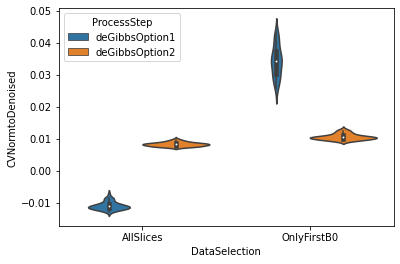

In [19]:
#################################################################################
## How does the data look like?
#################################################################################
dfdeGibbsComparison = pd.read_pickle("/home/mkeuken1/Documents/Projects/AHEAD-DWI-Preprocessing/tmp/degibbs-comparison/dfdeGibbsComparison.pkl")
# We only want to check the CVNormtoDenoised rows:
dfdeGibbsComparisonSel = dfdeGibbsComparison[dfdeGibbsComparison['ProcessStep'] != 'Denoised'].reset_index(drop=True)
# And how does it look?
ax = sns.violinplot(x="DataSelection", y="CVNormtoDenoised", hue="ProcessStep", data=dfdeGibbsComparisonSel)

# Lower than 0 would be better than the denoised image, above 0 would be worse.
# Based on the image it matters quite a bit which method you use depending on which scans:
#################################################################################

In [ ]:
#################################################################################
## 5. Degibbs of the TOPUP input files
#################################################################################
# Given the visual inspection of the two methods and stability I've decided to use 
#. the MRtrix3 method. We already have done the dwi data but we still need to do 
#. this for the topup input data:
for i in range(len(subjects)):
    work_dir = '/home/mkeuken1/Documents/Projects/AHEAD-DWI-Preprocessing/tmp/dwi_preprocessing/'+subjects[i]
    denoise_tp_dir = '/denoise_tp'
    degibbs2_tp_dir = '/degibbs-option2_tp'
    if (os.path.exists(work_dir+degibbs2_tp_dir)):
        print('De-Gibbs topup ringing by MRtrix: done (delete dir to recompute)')
    else:
        print('\n5d. De-Gibbs denoised topup DWI files (MRtrix version)')
        os.makedirs(work_dir+degibbs2_tp_dir,exist_ok=True)

        command = 'mrdegibbs -nthreads 4 -axes 0,1'
        command = command +' '+work_dir+denoise_tp_dir+'/dti_tp_denoised.mif.gz'
        command = command +' '+work_dir+degibbs2_tp_dir+'/dti_tp_unring2.mif.gz'

        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)

        command = 'mrconvert '
        command = command +' '+work_dir+degibbs2_tp_dir+'/dti_tp_unring2.mif.gz'
        command = command +' '+work_dir+degibbs2_tp_dir+'/dti_tp_unring2.nii.gz'

        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)
#################################################################################

In [ ]:
#################################################################################
## 6. Apply TOPUP to the data
#################################################################################
# Note that Topup takes forever so we are going to use multiprocessing
def topup_images(subject):
    work_dir = '/home/mkeuken1/Documents/Projects/AHEAD-DWI-Preprocessing/tmp/dwi_preprocessing/'+subject
    topup_dir = '/topup'
    degibbs1_dir = '/degibbs-option1'
    degibbs2_dir = '/degibbs-option2'
    degibbs2_tp_dir = '/degibbs-option2_tp'
    
    if (os.path.exists(work_dir+topup_dir)):
        print('Topup: done (delete dir to recompute)')
    else:
        print('\n6. Top-up geometric distortion correction')
        print(subject)
        os.makedirs(work_dir+topup_dir,exist_ok=True)
        
        # top-up requires an even number of slices: pad if necessary
        img = nighres.io.load_volume(work_dir+degibbs2_dir+'/dti_unring2.nii.gz')
        data = img.get_fdata()

        if (data.shape[2]%2==1):
            padded = np.zeros((data.shape[0],data.shape[1],data.shape[2]+1,data.shape[3]))
            padded[0:data.shape[0],0:data.shape[1],0:data.shape[2],0:data.shape[3]] = data
        else:
            padded = data

        img = nib.Nifti1Image(padded, affine=img.affine,header=img.header)
        nighres.io.save_volume(work_dir+topup_dir+'/dti.nii.gz', img)

        shutil.copy(work_dir+degibbs1_dir+'/dti_denoised.bval',work_dir+topup_dir+'/dti.bval')
        shutil.copy(work_dir+degibbs1_dir+'/dti_denoised.bvec',work_dir+topup_dir+'/dti.bvec')

        img = nighres.io.load_volume(work_dir+degibbs2_tp_dir+'/dti_tp_unring2.nii.gz')
        data = img.get_fdata()

        if (data.shape[2]%2==1):
            padded = np.zeros((data.shape[0],data.shape[1],data.shape[2]+1,data.shape[3]))
            padded[0:data.shape[0],0:data.shape[1],0:data.shape[2],0:data.shape[3]] = data
        else:
            padded = data

        img = nib.Nifti1Image(padded, affine=img.affine, header=img.header)
        nighres.io.save_volume(work_dir+topup_dir+'/dti_tp.nii.gz', img)

        # run the fsl script
        # 1. (extract total readout time from DICOM files)
        totreadout_main = total_readout_time
        totreadout_topup = total_readout_topup

        # 2. (merge all B0 from normal and topup acquisitions)
        command = 'dwiextract -bzero'
        command = command +' -fslgrad '+work_dir+topup_dir+'/dti.bvec '+work_dir+topup_dir+'/dti.bval'
        command = command +' '+work_dir+topup_dir+'/dti.nii.gz'
        command = command +' '+work_dir+topup_dir+'/b0.nii.gz'

        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)

        shutil.copy(work_dir+topup_dir+'/dti_tp.nii.gz', work_dir+topup_dir+'/b0_tp.nii.gz')

        command = 'mrcat -axis 3 '
        command = command +' '+work_dir+topup_dir+'/b0.nii.gz'
        command = command +' '+work_dir+topup_dir+'/b0_tp.nii.gz'
        command = command +' '+work_dir+topup_dir+'/b0_all.nii.gz'

        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)

        # 3. (build the corresponding acquisition parameter file)
        acqfile = open(work_dir+topup_dir+'/acqparams.txt', 'w')
        b0_img = nighres.io.load_volume(work_dir+topup_dir+'/b0.nii.gz')
        b0_tp_img = nighres.io.load_volume(work_dir+topup_dir+'/b0_tp.nii.gz')
        for i in range(b0_img.header.get_data_shape()[3]):
            acqfile.write("0 1 0 "+str(totreadout_main)+"\n")
        for i in range(b0_tp_img.header.get_data_shape()[3]):
            acqfile.write("0 -1 0 "+str(totreadout_topup)+"\n")
        acqfile.close()

        idxfile = open(work_dir+topup_dir+'/index.txt', 'w')
        dti_img = nighres.io.load_volume(work_dir+topup_dir+'/dti.nii.gz')
        for i in range(dti_img.header.get_data_shape()[3]):
            idxfile.write("1  ")
        idxfile.close()

        # 4. (run topup)
        # Note that we are using a custom b02b0_hires config file where we 
        # increased the resolution and updated the subsample steps:
        # warpres: 2.5; subsample: 1; smoothing: 0; miter: 25
        command = 'topup --imain='+work_dir+topup_dir+'/b0_all.nii.gz'
        command = command +' --datain='+work_dir+topup_dir+'/acqparams.txt'
        command = command +' --config=scripts/b02b0_hires.cnf'
        command = command +' --out='+work_dir+topup_dir+'/topup'
        command = command +' --fout='+work_dir+topup_dir+'/tfield'
        command = command +' --iout='+work_dir+topup_dir+'/topuped'

        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)

        # 5. (average A and P DWIs)
        command = 'fslmaths '+work_dir+topup_dir+'/topuped -Tmean '+work_dir+topup_dir+'/meanB0_AP'

        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)

        # 6. (mask with BET)
        command = 'bet '+work_dir+topup_dir+'/meanB0_AP '+work_dir+topup_dir+'/bet_meanB0_AP -f 0.1 -m -R'

        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)

if __name__ == '__main__':
    pool = Pool(2) # 2 threads out of the 32, more would interfer with the machine and other users
    pool.imap(topup_images, subjects) 
    pool.close()
#################################################################################

In [ ]:
#################################################################################
## 7. Appling eddy current correction to the files
#################################################################################
#. Also takes forever so use multiprocessing, 
#. but only with 2 cores as it is fairly intensive for memory and cpu
def eddyOpenMP(subject):
    work_dir = '/home/mkeuken1/Documents/Projects/AHEAD-DWI-Preprocessing/tmp/dwi_preprocessing/'+subject
    topup_dir = '/topup'
    eddy_dir = '/eddy'
    preprocessed_dir = '/preprocessed'
    print(subject)
    
    if (os.path.exists(work_dir+eddy_dir)):
        print('Eddy: done (delete dir to recompute)')
    else:
        print('\n7. Eddy current distortion correction')
        os.makedirs(work_dir+eddy_dir,exist_ok=True)
          
        # 7. (eddy)
        # It states that there was a multi band factor of 2?
        command = 'eddy_openmp --imain='+work_dir+topup_dir+'/dti.nii.gz'
        command = command +' --mask='+work_dir+topup_dir+'/bet_meanB0_AP_mask.nii.gz'
        command = command +' --acqp='+work_dir+topup_dir+'/acqparams.txt'
        command = command +' --index='+work_dir+topup_dir+'/index.txt'
        command = command +' --bvecs='+work_dir+topup_dir+'/dti.bvec'
        command = command +' --bvals='+work_dir+topup_dir+'/dti.bval'
        command = command +' --topup='+work_dir+topup_dir+'/topup'
        command = command +' --repol'
        command = command +' --out='+work_dir+eddy_dir+'/eddy_corr_data'
        command = command +' --nvoxhp=4000 --ol_nstd=3 --slm=linear --mb=2 --fwhm=10,0,0,0,0'

        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)
         
if __name__ == '__main__':
    pool = Pool(2) # 3 threads out of the 32
    pool.imap(eddyOpenMP, subjects) 
    pool.close()
#################################################################################   

In [ ]:
#################################################################################
## 8. Use Ants to do a bias correction 
#################################################################################
def biascorrection(subject):
    work_dir = '/home/mkeuken1/Documents/Projects/AHEAD-DWI-Preprocessing/tmp/dwi_preprocessing/'+subject
    topup_dir = '/topup'
    eddy_dir = '/eddy'
    biascorrection_dir = '/bias'
    print(subject)
    if (os.path.exists(work_dir+biascorrection_dir)):
        print('Bias correction: done (delete to recompute)')
    else:
        print('\n8. Bias correction')
        os.makedirs(work_dir+biascorrection_dir,exist_ok=True)
        print(subject)
        
        # Combine the eddy corrected data into a mif file
        command = 'mrconvert -fslgrad '+work_dir+topup_dir+'/dti.bvec'
        command = command +' '+work_dir+topup_dir+'/dti.bval'
        command = command +' '+work_dir+eddy_dir+'/eddy_corr_data.nii.gz'
        command = command +' '+work_dir+biascorrection_dir+'/'+subject+'_ses-3_dwi-preproc.mif.gz'

        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)

        # Run bias correction
        command = 'dwibiascorrect ants '+work_dir+biascorrection_dir+'/'+subject+'_ses-3_dwi-preproc.mif.gz'
        command = command +' '+work_dir+biascorrection_dir+'/'+subject+'_ses-3_dwi-preproc_unbiased.mif.gz'
        command = command +' -bias '+work_dir+biascorrection_dir+'/bias.mif'
        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)

        # Create a mask of the bias corrected data
        command = 'dwi2mask '+work_dir+biascorrection_dir+'/'+subject+'_ses-3_dwi-preproc_unbiased.mif.gz'
        command = command+' '+work_dir+biascorrection_dir+'/'+subject+'_mask.mif' 
        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)

        # Fill the internal holes of the mask
        # First convert it to nifti
        command = 'mrconvert '+work_dir+biascorrection_dir+'/'+subject+'_mask.mif '+work_dir+biascorrection_dir+'/'+subject+'_mask.nii.gz' 
        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)
        # then fill holes
        command = 'fslmaths '+work_dir+biascorrection_dir+'/'+subject+'_mask.nii.gz'
        command = command+' -bin -fillh '+work_dir+biascorrection_dir+'/'+subject+'_mask_filled.nii.gz'
        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)
        # Convert back to mif
        command = 'mrconvert '+work_dir+biascorrection_dir+'/'+subject+'_mask_filled.nii.gz '+work_dir+biascorrection_dir+'/'+subject+'_mask_filled.mif.gz' 
        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)
            
        # Clean up 
        # Remove the combined pre proc files as they take quite some space
        command = 'rm '+work_dir+biascorrection_dir+'/'+subject+'_ses-3_dwi-preproc.mif.gz'
        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)
        
if __name__ == '__main__':
    pool = Pool(3) # 3 threads out of the 32
    pool.imap(biascorrection, subjects) 
    pool.close()
#################################################################################      

In [ ]:
#################################################################################
## 9. Fit a tensor model to the final processed dataset to be able to check the results
#################################################################################
def finalImage(subject):
    work_dir = '/home/mkeuken1/Documents/Projects/AHEAD-DWI-Preprocessing/tmp/dwi_preprocessing/'+subject
    biascorrection_dir = '/bias'
    preprocessed_dir = '/preprocessed'
    print(subject)
        
    if (os.path.exists(work_dir+preprocessed_dir)):
        print('Final DWI image: done (delete to recompute)')
    else:
        print('\n8. Final image creation and tensor contrasts')
        os.makedirs(work_dir+preprocessed_dir,exist_ok=True)
        # Copy the data from the bias correction folder to the preprocessed folder
        shutil.move(work_dir+biascorrection_dir+'/'+subject+'_ses-3_dwi-preproc_unbiased.mif.gz', work_dir+preprocessed_dir+'/'+subject+'_ses-3_dwi-preproc_unbiased.mif.gz')
        shutil.move(work_dir+biascorrection_dir+'/'+subject+'_mask_filled.mif.gz', work_dir+preprocessed_dir+'/'+subject+'_mask.mif.gz')
        
        # Fit a tensor model to the DWI data to check the vector data as a sanity check
        command = 'dwi2tensor '+work_dir+preprocessed_dir+'/'+subject+'_ses-3_dwi-preproc_unbiased.mif.gz '+work_dir+preprocessed_dir+'/'+subject+'_ses-3_dti-tensor.mif.gz'
        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)

        command = 'tensor2metric -fa '+work_dir+preprocessed_dir+'/'+subject+'_ses-3_dti-fa.nii.gz -adc '+work_dir+preprocessed_dir+'/'+subject+'_ses-3_dti-adc.nii.gz -vec '+work_dir+preprocessed_dir+'/'+subject+'_ses-3_dti-vec.nii.gz '+work_dir+preprocessed_dir+'/'+subject+'_ses-3_dti-tensor.mif.gz'
        print(command)
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)

if __name__ == '__main__':
    pool = Pool(3) # 3 threads out of the 32
    pool.imap(finalImage, subjects) 
    pool.close()
#################################################################################

In [ ]:
#################################################################################
## 10. Move the preprocessed files to the public AHEAD BIDS folder
#################################################################################
# As I was working in my own local copy of the data we need to move the final 
#. preprocessed data to the public AHEAD BIDS data folder:
for i in range(len(subjects)):
    # Folder settings 
    work_dir = '/home/mkeuken1/Documents/Projects/AHEAD-DWI-Preprocessing/tmp/dwi_preprocessing/'+subjects[i]
    preprocessed_dir = '/preprocessed'
    output_dir_public = '/home/public/HumanAtlas_BIDS/'+subjects_bids[i]+'/ses-3/dwi'
    
    print(subjects[i], subjects_bids[i] )
    try:
        shutil.move(work_dir+preprocessed_dir+'/'+subjects[i]+'_ses-3_dwi-preproc_unbiased.mif.gz', output_dir_public+'/'+subjects_bids[i]+'_ses-3_dwi-preproc.mif.gz')
        shutil.move(work_dir+preprocessed_dir+'/'+subjects[i]+'_mask.mif.gz', output_dir_public+'/'+subjects_bids[i]+'_ses-3_dwi_mask.mif.gz')
    except:
        continue
#################################################################################

In [ ]:
#################################################################################
## Done! 
##
## You should have ended up with a preprocessed DWI dataset that you can use 
##   for mrtrix and create connectomes with it etc.
## This will be done in a seperate notebook.
#################################################################################